In [90]:
from models import models
from utils import *
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from models.keras_vision_transformer import transformer_layers
from models.keras_vision_transformer import swin_layers
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## DL Approaches

In [115]:

MODEL_NAME = "Attn-Unet-pretrained"
MODEL_NAME = "SWIN-Unet"
MODEL_NAME = "CASPIAN"

MODEL_NAME = "CASPIAN_beta"
MODEL_NAME = "CASPIAN_beta_v2"
#MODEL_NAME = "CASPIAN_beta_v3"
#MODEL_NAME = "CASPIAN_beta_v4"


output_1d = False
the_mask = get_the_mask()

amae = []
armse = []
ar2 = []
delta_05 = []
delta_01 = []
acc = []
artae = []

amae_h = []
armse_h = []
ar2_h = []
delta_05_h = []
delta_01_h = []
acc_h = []
artae_h = []

if "_" in MODEL_NAME:
    splits = 2
else:
    splits = 4

for split in range(1,splits):
    #Loading the eval. datasets
    ds_eval = {
        'test': tf.data.Dataset.load("./data/test_ds_split_%d" % split),
        'holdout': tf.data.Dataset.load("./data/holdout_dataset"),
    }
    if "Attn" in MODEL_NAME:
        ds_eval['test'] = ds_eval['test'].map(lambda f,x,y, yf: expand_input_channels_full(f,x,y, yf))
        ds_eval['holdout'] = ds_eval['holdout'].map(lambda f,x,y, yf: expand_input_channels_full(f,x,y, yf))
    
    ds_eval['test'] = ds_eval['test'].batch(1)
    ds_eval['holdout'] = ds_eval['holdout'].batch(1)
    
    model = tf.keras.models.load_model("./models/trained_models/"+MODEL_NAME+"_split_{}".format(str(split)), 
                                       compile=False, 
                                       custom_objects={"patch_extract": transformer_layers.patch_extract,
                                                      "patch_embedding": transformer_layers.patch_embedding,
                                                      "SwinTransformerBlock": swin_layers.SwinTransformerBlock,
                                                      "patch_merging": transformer_layers.patch_merging,
                                                      "patch_expanding": transformer_layers.patch_expanding})
    model.summary()
    ypred = []
    ypred_h = []
    ytest = []
    yhold = []
    
    for sample in ds_eval['test'].as_numpy_iterator():
        scenario, input_grid, label, label_flat = sample
        pred = model.predict(input_grid)[0, :, :, 0]
        pred = pred[the_mask]
        label = label[0, :, :][the_mask]
        ypred.append(pred)
        ytest.append(label)
        
    for sample in ds_eval['holdout'].as_numpy_iterator():
        scenario, input_grid, label, label_flat = sample
        pred = model.predict(input_grid)[0, :, :, 0]
        pred = pred[the_mask]
        label = label[0, :, :][the_mask]
        ypred_h.append(pred)
        yhold.append(label)
    
    ypred = np.array(ypred)
    ypred_h = np.array(ypred_h)
    ytest = np.array(ytest)
    yhold = np.array(yhold)
    print(ypred.shape, ypred_h.shape)
    amae.extend(mean_absolute_error(ytest.T, ypred.T, multioutput='raw_values'))
    amae_h.extend(mean_absolute_error(yhold.T, ypred_h.T, multioutput='raw_values'))

    armse.extend(mean_squared_error(ytest.T, ypred.T, squared=False, multioutput='raw_values'))
    armse_h.extend(mean_squared_error(yhold.T, ypred_h.T, squared=False, multioutput='raw_values'))

    artae.extend(artae_score(ytest, ypred))
    artae_h.extend(artae_score(yhold, ypred_h))

    delta_05.extend(delta_score(ytest, ypred, 0.5))
    delta_05_h.extend(delta_score(yhold, ypred_h, 0.5))

    delta_01.extend(delta_score(ytest, ypred, 0.1))
    delta_01_h.extend(delta_score(yhold, ypred_h, 0.1))

    ar2.extend(r2_score(ytest.T, ypred.T, multioutput='raw_values'))
    ar2_h.extend(r2_score(yhold.T, ypred_h.T, multioutput='raw_values'))

    acc.extend(acc0(ytest, ypred))
    acc_h.extend(acc0(yhold, ypred_h))

        

print("\n------- Results on the Test dataset -------------")
print("\nAverage Mean Absolute Erorr: %.5f +- %.5f" % (np.mean(amae), np.std(amae)))
print("\nAverage Root Mean Squared Erorr: %.5f +- %.5f" % (np.mean(armse), np.std(armse)))
print("\nAverage Relative Total Absolute Error: %.5f +- %.5f" % (np.mean(artae), np.std(artae)))
print("\nAverage delta_05_err: %.5f %% +- %.5f" % (np.mean(delta_05), np.std(delta_05)))
print("\nAverage delta_01_err: %.5f %% +- %.5f" % (np.mean(delta_01), np.std(delta_01)))
print("\nAverage R2 score: %.5f +- %.5f" % (np.mean(ar2), np.std(ar2)))
print("\nAverage Accuracy (of 0s): %.5f %% +- %.5f" % (np.mean(acc), np.std(acc)))

print("\n------- Results on the Holdout dataset -------------")
print("\nAverage Mean Absolute Erorr: %.5f +- %.5f" % (np.mean(amae_h), np.std(amae_h)))
print("\nAverage Root Mean Squared Erorr: %.5f +- %.5f" % (np.mean(armse_h), np.std(armse_h)))
print("\nAverage Relative Total Absolute Error: %.5f +- %.5f" % (np.mean(artae_h), np.std(artae_h)))
print("\nAverage delta_05_err: %.5f %% +- %.5f" % (np.mean(delta_05_h), np.std(delta_05_h)))
print("\nAverage delta_01_err: %.5f %% +- %.5f" % (np.mean(delta_01_h), np.std(delta_01_h)))
print("\nAverage R2 score: %.5f +- %.5f" % (np.mean(ar2_h), np.std(ar2_h)))
print("\nAverage Accuracy (of 0s): %.5f %% +- %.5f" % (np.mean(acc_h), np.std(acc_h)))

Length of the masked points: 12066
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 1024, 1024,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 1024, 1024,   0           ['lambda[0][0]']                 
                                1)                         

## Traditional ML Approaches & Baseline

In [92]:
mode = "ML"

model_name = "baseline"
model_name = "linear"
model_name = "krig"
model_name = "svr"
model_name = "poly_lasso"

amae = []
armse = []
ar2 = []
delta_05 = []
delta_01 = []
acc = []
artae = []

amae_h = []
armse_h = []
ar2_h = []
delta_05_h = []
delta_01_h = []
acc_h = []
artae_h = []


for split in range(1,4):
    if "basel" in model_name:
        xdata, ydata, xtest, ytest, xhold, yhold = tfDS_to_np (split=split, baseline=True)
    else:
        xdata, ydata, xtest, ytest, xhold, yhold = tfDS_to_np (split=split)
    
    if model_name == "krig":
        Z, pcs, means = PCA(ydata)
        tt = np.dot(Z, pcs) + means
        tt = tt - ydata
        print("Loss due to PCA: %.15f " % tt.sum())
        model = Kriging(xdata, Z, corr='abs_exp', poly='linear')
        ypred = np.dot(model.predict_values(xtest), pcs) + means
        ypred_h = np.dot(model.predict_values(xhold), pcs) + means
    elif model_name == "svr":
        print ("Fitting split %d ....." % split)
        base = SVR(C=5, epsilon=0.05, kernel="linear")
        model = MultiOutputRegressor(base, n_jobs=-1).fit(xdata, ydata)
        ypred = model.predict(xtest)
        ypred_h = model.predict(xhold)
    elif model_name == 'linear':
        print ("Fitting split %d ....." % split)
        model = linear_model.LinearRegression().fit(xdata, ydata)
        ypred = model.predict(xtest)
        ypred_h = model.predict(xhold)
    elif model_name == 'poly_lasso':
        print ("Fitting split %d ....." % split)
        poly = PolynomialFeatures(interaction_only=True)
        poly_xdata = poly.fit_transform(xdata)
        print("Shape of the input %s" % str(poly_xdata.shape))
        model = linear_model.Lasso(alpha=0.025, max_iter=2000).fit(poly_xdata, ydata)
        poly_xtest = poly.fit_transform(xtest)
        poly_xhold = poly.fit_transform(xhold)
        ypred = model.predict(poly_xtest)
        ypred_h = model.predict(poly_xhold)
    else:
        print ("Fitting split %d ....." % split)
        avg_pwl = dataset_average_pwl(ydata)
        ypred =  simple_predictor(xtest, avg_pwl)
        ypred_h = simple_predictor(xhold, avg_pwl)
    ypred [ypred < 0] = 0
    ypred_h [ypred_h < 0] = 0
    
    amae.extend(mean_absolute_error(ytest.T, ypred.T, multioutput='raw_values'))
    amae_h.extend(mean_absolute_error(yhold.T, ypred_h.T, multioutput='raw_values'))
    
    armse.extend(mean_squared_error(ytest.T, ypred.T, squared=False, multioutput='raw_values'))
    armse_h.extend(mean_squared_error(yhold.T, ypred_h.T, squared=False, multioutput='raw_values'))
    
    artae.extend(artae_score(ytest, ypred))
    artae_h.extend(artae_score(yhold, ypred_h))
    
    delta_05.extend(delta_score(ytest, ypred, 0.5))
    delta_05_h.extend(delta_score(yhold, ypred_h, 0.5))
    
    delta_01.extend(delta_score(ytest, ypred, 0.1))
    delta_01_h.extend(delta_score(yhold, ypred_h, 0.1))
    
    ar2.extend(r2_score(ytest.T, ypred.T, multioutput='raw_values'))
    ar2_h.extend(r2_score(yhold.T, ypred_h.T, multioutput='raw_values'))
    
    acc.extend(acc0(ytest, ypred))
    acc_h.extend(acc0(yhold, ypred_h))



print("\n------- Results on the Test dataset -------------")
print("\nAverage Mean Absolute Erorr: %.5f +- %.5f" % (np.mean(amae), np.std(amae)))
print("\nAverage Root Mean Squared Erorr: %.5f +- %.5f" % (np.mean(armse), np.std(armse)))
print("\nAverage Relative Total Absolute Error: %.5f +- %.5f" % (np.mean(artae), np.std(artae)))
print("\nAverage delta_05_err: %.5f %% +- %.5f" % (np.mean(delta_05), np.std(delta_05)))
print("\nAverage delta_01_err: %.5f %% +- %.5f" % (np.mean(delta_01), np.std(delta_01)))
print("\nAverage R2 score: %.5f +- %.5f" % (np.mean(ar2), np.std(ar2)))
print("\nAverage Accuracy (of 0s): %.5f %% +- %.5f" % (np.mean(acc), np.std(acc)))

print("\n------- Results on the Holdout dataset -------------")
print("\nAverage Mean Absolute Erorr: %.5f +- %.5f" % (np.mean(amae_h), np.std(amae_h)))
print("\nAverage Root Mean Squared Erorr: %.5f +- %.5f" % (np.mean(armse_h), np.std(armse_h)))
print("\nAverage Relative Total Absolute Error: %.5f +- %.5f" % (np.mean(artae_h), np.std(artae_h)))
print("\nAverage delta_05_err: %.5f %% +- %.5f" % (np.mean(delta_05_h), np.std(delta_05_h)))
print("\nAverage delta_01_err: %.5f %% +- %.5f" % (np.mean(delta_01_h), np.std(delta_01_h)))
print("\nAverage R2 score: %.5f +- %.5f" % (np.mean(ar2_h), np.std(ar2_h)))
print("\nAverage Accuracy (of 0s): %.5f %% +- %.5f" % (np.mean(acc_h), np.std(acc_h)))

Fitting split 1 .....
Shape of the input (124, 154)


C:\Users\ak7550\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Fitting split 2 .....
Shape of the input (124, 154)


C:\Users\ak7550\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Fitting split 3 .....
Shape of the input (124, 154)


C:\Users\ak7550\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



------- Results on the Test dataset -------------

Average Mean Absolute Erorr: 0.14680 +- 0.05038

Average Root Mean Squared Erorr: 0.42085 +- 0.15737

Average Relative Total Absolute Error: 22.54650 +- 55.64586

Average delta_05_err: 5.45426 % +- 2.65474

Average delta_01_err: 16.28221 % +- 5.16932

Average R2 score: 0.95173 +- 0.03476

Average Accuracy (of 0s): 10.81468 % +- 3.82625

------- Results on the Holdout dataset -------------

Average Mean Absolute Erorr: 0.16157 +- 0.08255

Average Root Mean Squared Erorr: 0.46112 +- 0.22012

Average Relative Total Absolute Error: 7.09558 +- 2.42885

Average delta_05_err: 6.72922 % +- 3.07131

Average delta_01_err: 14.32503 % +- 4.58936

Average R2 score: 0.95746 +- 0.05010

Average Accuracy (of 0s): 10.85503 % +- 4.60186


## Visualize Predictions

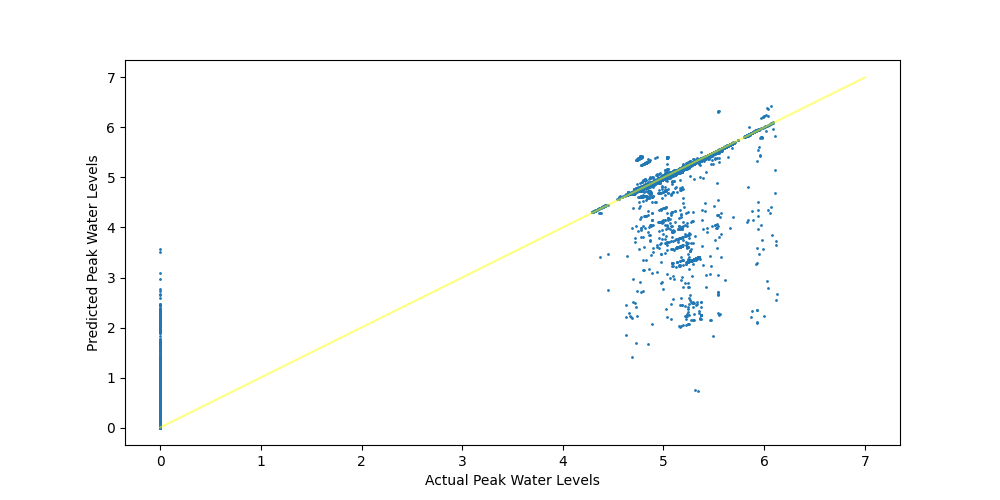

In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
%matplotlib widget

colors = [(1, 1, 1),
          (0, 1, 0),  
          (1.0, 0, 0.0)]  # Color for 1 (red)

# Create a ListedColormap
incmap = ListedColormap(colors)

colors = [(0.863, 0.824, 0.80),  # Very light gray for 0
          (0.0, 0.0, 1.0),    # Blue for (0, 1]
          (0.098, 0.098, 0.439),    # Dark blue for (1, 2]
          (0.627, 0.125, 0.941),    # Violet for (2, 3]
          (0.294, 0, 0.51),    # Dark violet for (3, 4]
          (0.855, 0.439, 0.839)]    # Red for > 4
outcmap = ListedColormap(colors)
boundaries = [0, 4, 4.5, 5, 5.5, 7.0]
outnorm = BoundaryNorm(boundaries, outcmap.N, clip=True)

ds_eval = {
    'test': tf.data.Dataset.load("./data/test_ds_split_%d" % split),
    'holdout': tf.data.Dataset.load("./data/holdout_dataset"),
}


if mode != "ML":
    scenario = "00000001111110000.input.npy"
    plt.close()
    fig, axs = plt.subplots(1,3, figsize=(12, 6), facecolor='w', edgecolor='k')
    fig.tight_layout(pad=2, h_pad=1.5, w_pad=0)
    axs = axs.ravel()

    ds = ds_eval['holdout'].filter(find_scenario(scenario))
    if (len(list(ds.as_numpy_iterator()))) != 0:

        for sample in ds.as_numpy_iterator():
            scenario, input_grid, label, label_flat = sample
            pred = model.predict(input_grid)[0, :, :, 0]
            pred[~the_mask] = 0
            axs[0].imshow(input_grid[0, :, :], cmap=incmap, origin="lower", interpolation='none', aspect='auto')
            axs[0].set_title(scenario[0])
            axs[1].imshow(label[0, :, :], cmap=outcmap, norm=outnorm, origin="lower", interpolation='none', aspect='auto')
            axs[1].set_title("Ground Truth")
            axs[2].imshow(pred, cmap=outcmap, norm=outnorm, origin="lower", interpolation='none', aspect='auto')
            axs[2].set_title("Prediction")
            print("Ground Truth MinMax: %f %f" % (label.min(), label.max()))
            print("Prediction MinMax: %f %f " % (pred.min(), pred.max()))
            fig = plt.figure(figsize=(10, 5))
            ax = fig.gca()
            ax.scatter(label[0, :, :][the_mask], pred[the_mask], s=1)
            ax.plot([0, 7], [0,7], color="yellow", alpha=0.5)
            ax.set_xlabel("Actual Peak Water Levels")
            ax.set_ylabel("Predicted Peak Water Levels")
            plt.show()
    else:
        print("Scenario not found")
else:
    model.predict(xhold[0].reshape(1, -1))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()
    ax.scatter(yhold[0], ypred_h[0], s=1)
    ax.plot([0, 7], [0,7], color="yellow", alpha=0.5)
    ax.set_xlabel("Actual Peak Water Levels")
    ax.set_ylabel("Predicted Peak Water Levels")
    plt.show()